# Experiment 4: Spinal stimulation (4D)

In this tutorial, we will use the `optim-neurostim` library to perform a 4D spinal stimulation spatio-temporal optimization.

Here we will use a toy dataset based on real data. Stimuli delivered in the rat spinal cord, once at each step, are associated with different step heights. We will optimize the position (lumbar or sacral), the frequency, duration and timing of the stimulation in order to maximize the step height.

## Step 1: Download dependencies

In [1]:
from IPython.display import Image, display
from PIL import Image as PIL_Image
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'size': 16} 
matplotlib.rc('font', **font)

In [2]:
%cd ..

/Users/uzaymacar/Desktop/EduOptimNeurostimDev


In [ ]:
#!pip install GPy

## Step 2: Download the dataset

In [ ]:
!bash scripts/download_nhp_rat_dataset.sh data

## Step 3: Configuration file

In `optim-neurostim`, the training is orchestrated by a configuration file, a JSON file containing all the necessary parameters.  Some examples of configuration files are available in the `optim-neurostim/examples/` folder.

In this tutorial for Experiment 4, we will be using the configuration file: `optim-neurostim/examples/rat_mapping_4D_spinal_stimulation.json`. This is already downloaded for you in `config` (📁).

Open this file and follow on for more information on some of the key parameters for performing the 2D rat mapping:

1. `seed` - The random seed for the experiment which enables reproducibility. We use `0` throughout all experiments.
> `"seed": 0`

2. `output_path` - The name of the folder that will be populated by the output files (e.g. the trained object, relevant plots, etc.)
> `"path_output": "output/rat_mapping_4D_spinal_stimulation"`

3. `prior:path` - The path to the prior object (`.mat`). We released a few prior objects for experimentation purposes and to speed-up training and these can be found under the `optim-neurostim/priors/` folder. In this experiment, we don't utilize any prior so we leave it empty.
> `"path": null`

4. `data:dataset_path` - The location to the dataset.
> `"dataset_path": "data/rat"`

5. `acquisition:kappa:values` - The values to assess in hyperparameter optimization for UCB acquisition function's kappa parameter.
> `"values": [2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.3, 4.5, 4.8]`

6. `acquisition:kappa:find_best` - Setting this parameter to true will enable hyperparameter optimization for the corresponding hyperparameter, e.g. `kappa` for this case.
> `"find_best": true`

7. `optimization:name` - The name of the optimization algorithm, which should be one of `gpbo`, `extensive`, or `greedy`. For this experiment, we will show GPBO.
> `"name": "gpbo"`

8. `optimization:n_repetitions` - Number of repetitions for the optimization algorithm.
> `"n_repetitions": 30`


## (Optional) Step 4: Play around with parameters

Optionally, you can open `examples/rat_mapping_4D_spinal_stimulation.json` and manually change any parameter you want before running the experiment. You can even create a config file from scratch if you wish to explore further!

## Step 5: Run optimization on one new animal

Using the given config file and given that the best hyperparameter value for `kappa` is $4.0$, let's first run optimization on one new animal. We do this by passing `"{'kappa': 4.0}"` or equivalently `output/rat_mapping_4D_spinal_stimulation/best_hyperparams.pkl` (i.e. path to the trained hyperparameter object) to the `-hp` flag.

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 1 \
                -op output/rat_mapping_4D_spinal_stimulation_one_animal \
                -hp "{'kappa': 4.0}" \
                -val

We can quickly check the performance through the saved CSV file.

In [ ]:
df_gpbo = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_one_animal/gpbo_performance.csv', index_col='queries')
df_gpbo = df_gpbo[['exploration', 'exploitation']].T
df_gpbo

Let's see what the `y_mu_mapped` looks like. This is the output of GP, `y_mu`, mapped to the dimensions of the problem. 

In [ ]:
y_mu_mapped_arr = np.squeeze(np.load('output/rat_mapping_4D_spinal_stimulation_one_animal/y_mu_mapped_arr.npy'))
print(y_mu_mapped_arr.shape)  
# NOTE: y_mu_mapped_arr is in shape (num_hyperparams, num_muscles, *system_shape) or (*system.shape) if squeeze-able
# plt.xticks(range(4), range(1, 5))
# plt.yticks(range(8), range(1, 9))
plt.imshow(y_mu_mapped_arr[:, :, 0, 0], cmap='OrRd')  
# TODO: Which values to show?
# TODO: Map indexes to values (e.g. f=50 Hz)
plt.colorbar()
plt.show()

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_one_animal/performance_vs_queries.png'))

Now, let's run the same pipeline, but using the **extensive** search algorithm instead of the **GPBO** search algorithm as employed before.

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 1 \
                -alg extensive \
                -op output/rat_mapping_4D_spinal_stimulation_one_animal_extensive \
                -hp "{'kappa': 4.0}" \
                -val 

We can quickly check the performance through the saved CSV file.

In [ ]:
df_extensive = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_one_animal_extensive/extensive_performance.csv', index_col='queries')
df_extensive = df_extensive[['exploration', 'exploitation']].T
df_extensive

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_one_animal_extensive/performance_vs_queries.png'))

Now, let's run the same pipeline, but using the **greedy** search algorithm instead of the **GPBO** search algorithm as employed before.

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 1 \
                -alg greedy \
                -op output/rat_mapping_4D_spinal_stimulation_one_animal_greedy \
                -hp "{'kappa': 4.0}" \
                -val

In [ ]:
df_greedy = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_one_animal_greedy/greedy_performance.csv', index_col='queries')
df_greedy = df_greedy[['exploration', 'exploitation']].T
df_greedy

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_one_animal_greedy/performance_vs_queries.png'))

Finally, we can compare the two algorithms on the same plot for (i) exploration and (ii) exploitation using the command given below.

In [ ]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_4D_spinal_stimulation_one_animal \
                                    -r2 output/rat_mapping_4D_spinal_stimulation_one_animal_extensive \
                                    -r3 output/rat_mapping_4D_spinal_stimulation_one_animal_greedy

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_one_animal/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_one_animal/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Step 6: Run optimization on several validation animals

We now do the same, but with several validation animals.

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 10 \
                -op output/rat_mapping_4D_spinal_stimulation_several_animals \
                -hp "{'kappa': 4.0}" \
                -val

We can quickly check the performance through the saved CSV file.

In [ ]:
df_gpbo = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_several_animals/gpbo_performance.csv', index_col='queries')
df_gpbo = df_gpbo[['exploration', 'exploitation']].T
df_gpbo

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_several_animals/performance_vs_queries.png'))

Now, let's run the same pipeline, but using the **extensive** search algorithm instead of the **GPBO** search algorithm as employed before.

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 10 \
                -alg extensive \
                -op output/rat_mapping_4D_spinal_stimulation_several_animals_extensive \
                -hp "{'kappa': 4.0}" \
                -val 

We can quickly check the performance through the saved CSV file.

In [ ]:
df_extensive = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_several_animals_extensive/extensive_performance.csv', index_col='queries')
df_extensive = df_extensive[['exploration', 'exploitation']].T
df_extensive

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_several_animals_extensive/performance_vs_queries.png'))

In [ ]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -nm 10 \
                -alg greedy \
                -op output/rat_mapping_4D_spinal_stimulation_several_animals_greedy \
                -hp "{'kappa': 4.0}" \
                -val 

In [ ]:
df_greedy = pd.read_csv('output/rat_mapping_4D_spinal_stimulation_several_animals_greedy/greedy_performance.csv', index_col='queries')
df_greedy = df_greedy[['exploration', 'exploitation']].T
df_greedy

In [ ]:
display(Image('output/rat_mapping_4D_spinal_stimulation_several_animals_greedy/performance_vs_queries.png'))

Finally, we can compare the two algorithms on the same plot for (i) exploration and (ii) exploitation using the command given below.

In [ ]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_4D_spinal_stimulation_several_animals \
                                    -r2 output/rat_mapping_4D_spinal_stimulation_several_animals_extensive \
                                    -r3 output/rat_mapping_4D_spinal_stimulation_several_animals_greedy

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_several_animals/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_several_animals/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Running validation on all replicates

In [30]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -op output/rat_mapping_4D_spinal_stimulation_all \
                -hp "{'kappa': 4.0}" \
                -val

Iterating over repetitions:  50%|███████▌       | 15/30 [00:35<00:34,  2.28s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
Hooray! Succesfully saved output files to output/rat_mapping_4D_spinal_stimulation_all.


In [26]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -alg extensive \
                -op output/rat_mapping_4D_spinal_stimulation_all_extensive \
                -hp "{'kappa': 4.0}" \
                -val

Iterating over repetitions:   0%|                        | 0/30 [00:00<?, ?it/s] main.py:469: RuntimeWarning:Mean of empty slice
 main.py:465: RuntimeWarning:invalid value encountered in multiply
Iterating over the system:  83%|███████████████   | 5/6 [00:01<00:00,  4.31it/s] main.py:169: RuntimeWarning:invalid value encountered in multiply
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning:invalid value encountered in reduce
Hooray! Succesfully saved output files to output/rat_mapping_4D_spinal_stimulation_all_extensive.


In [27]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -alg greedy \
                -op output/rat_mapping_4D_spinal_stimulation_all_greedy \
                -hp "{'kappa': 4.0}" \
                -val 

Iterating over repetitions:   0%|                        | 0/30 [00:00<?, ?it/s] main.py:469: RuntimeWarning:Mean of empty slice
 main.py:465: RuntimeWarning:invalid value encountered in multiply
Iterating over the system:  67%|████████████      | 4/6 [00:01<00:00,  2.22it/s] main.py:169: RuntimeWarning:invalid value encountered in multiply
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning:invalid value encountered in reduce
Hooray! Succesfully saved output files to output/rat_mapping_4D_spinal_stimulation_all_greedy.


In [28]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_4D_spinal_stimulation_all \
                                    -r2 output/rat_mapping_4D_spinal_stimulation_all_extensive \
                                    -r3 output/rat_mapping_4D_spinal_stimulation_all_greedy

Hooray! Successfully compared and plotted the runs!


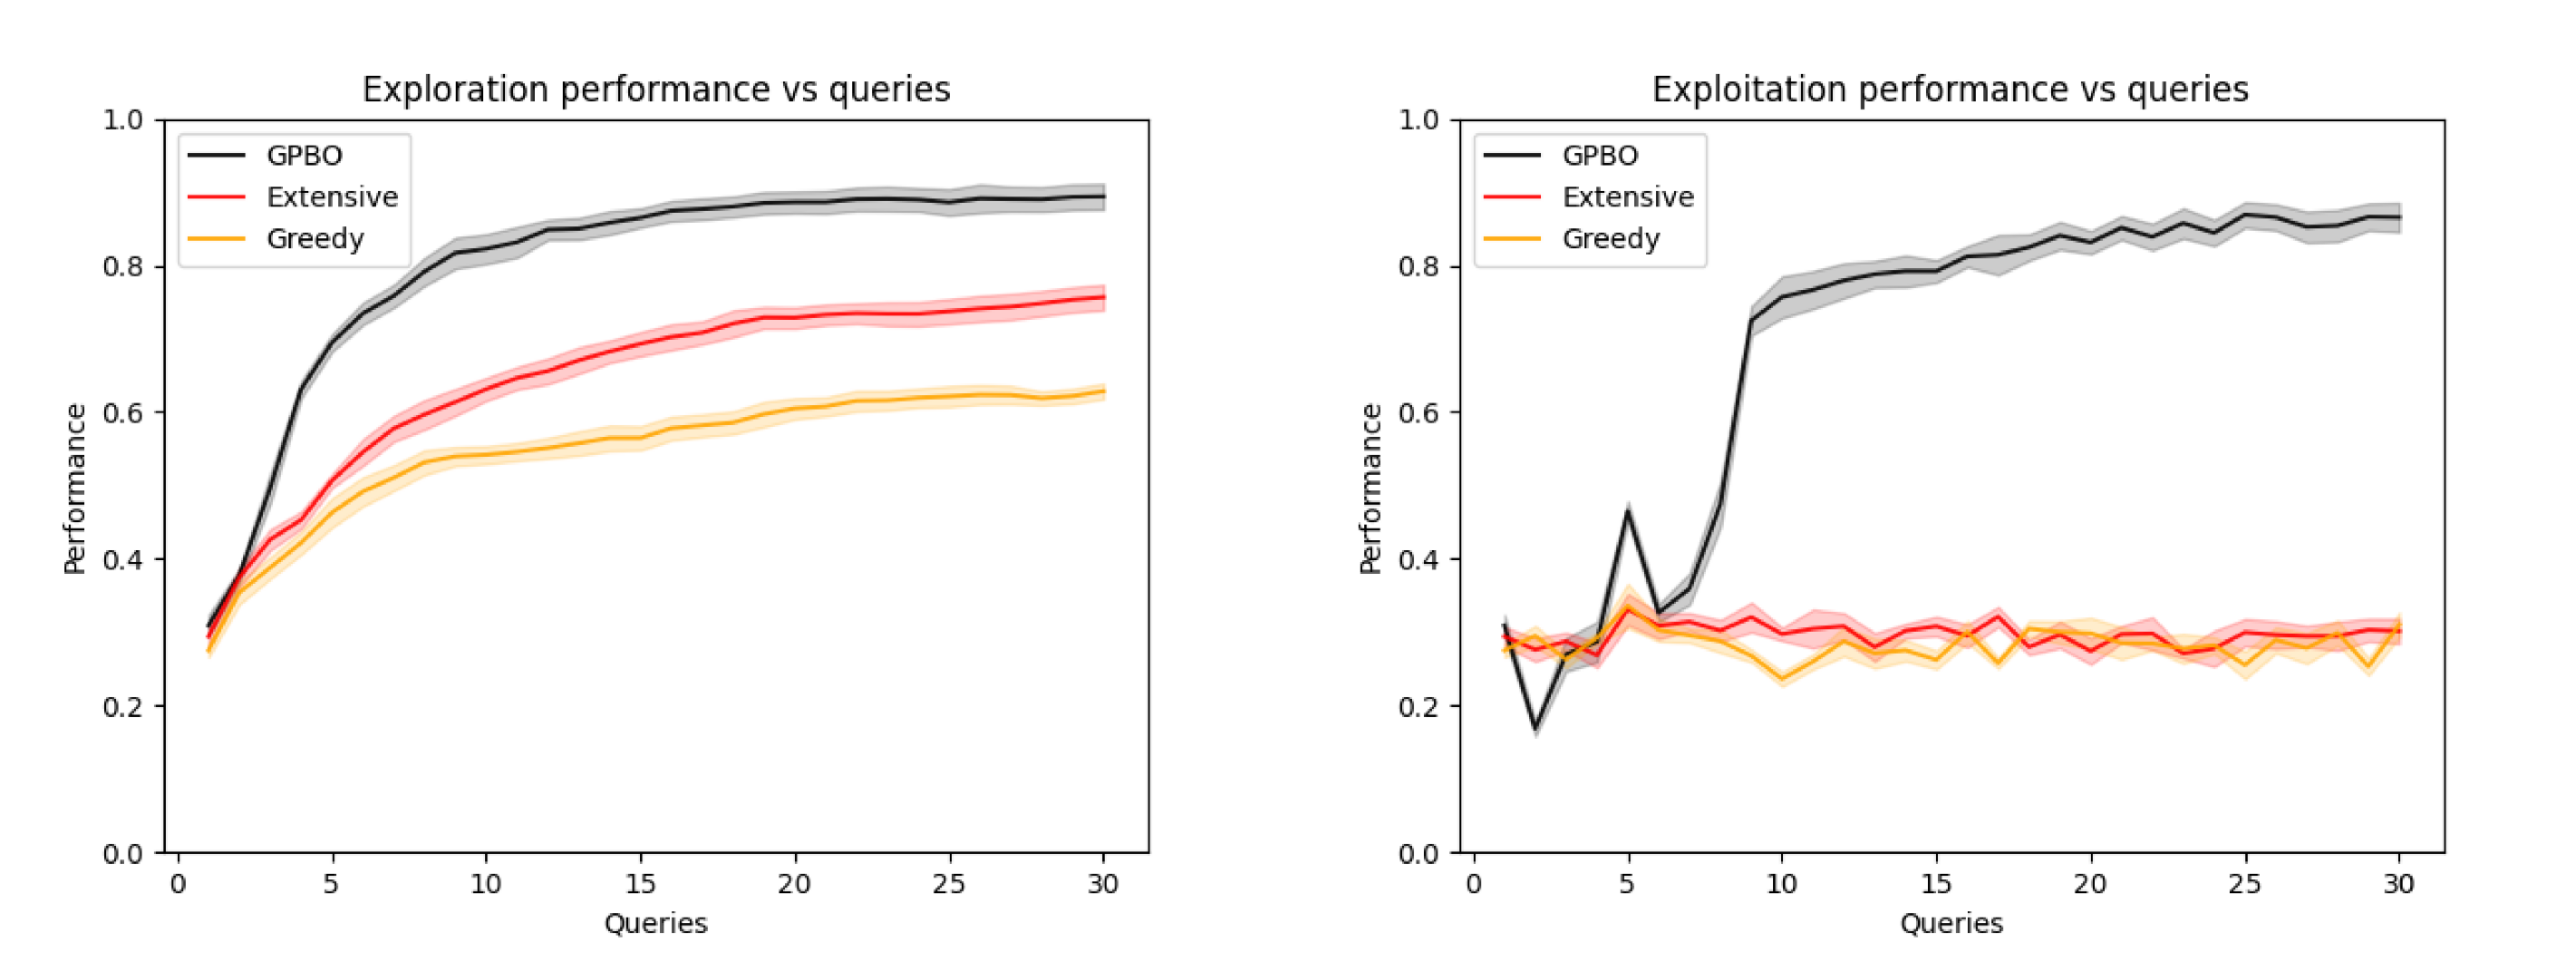

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_all/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_4D_spinal_stimulation_all/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Step 7: Run offline hyperpamater optimization

Now that we saw how `optim-neurostim` can be utilized to run validation experiments, let's see how we decided on the best value for `kappa`. Now, we will run the command without any additional flags to perform offline hyperparameter optimization. As discussed before, the config file encodes all of the necessary information.

In [19]:
!python main.py -c config/rat_mapping_4D_spinal_stimulation.json \
                -op output/rat_mapping_4D_spinal_stimulation

Iterating over repetitions:  40%|██████         | 12/30 [00:28<00:40,  2.23s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
Iterating over repetitions:  73%|███████████    | 22/30 [00:48<00:18,  2.33s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
Hooray! Succesfully saved output files to output/rat_mapping_4D_spinal_stimulation.


Let's first see what the algorithmic performance looks like for different values of hyperparameter `kappa`.

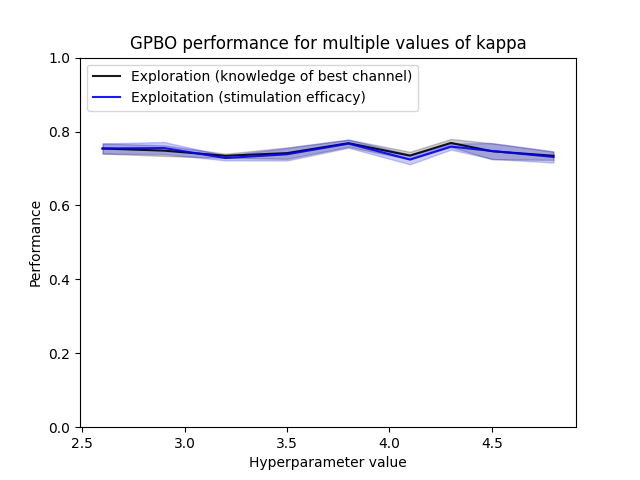

In [20]:
display(Image('output/rat_mapping_4D_spinal_stimulation/performance_for_kappa.png'))

This command also gives us a `.pkl` containing the best values for hyperparameters which we can pass onto validation experiments later. Let's investigate this below.

In [21]:
with open('output/rat_mapping_4D_spinal_stimulation/best_hyperparams.pkl', 'rb') as f:
    d = pickle.load(f)

print(d)

{'kappa': 3.8}
